In [1]:
#%load_ext autoreload
#%autoreload 2
    
import pandas as pd  
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion #, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split #, cross_val_score, GridSearchCV
from sklearn import metrics
#from sklearn.neural_network import MLPClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from myScripts.transformer import ColumnSelector, DenseTransformer, ProcessRiskDescriptionTransformer 
from myScripts.plots import percAvailableData, percAvailableDataFeature, createConfusionMatrix
from myScripts.dataframes import removeFeatures, createDataframeTarget, getDataAboveTreshhold, getTargetCategoriesAndCounts
from myScripts.lists import getColumnList

%matplotlib inline

In [2]:
my_df = pd.read_excel('TestDataNC.xlsx')

In [3]:
# non relevant features are being removed
with open('drop.txt', 'r') as f:
    for line in f:
        my_df = my_df.drop([line.rstrip()], axis=1)

In [4]:
# get target feature name
with open('target.txt', 'r') as f:
    for line in f:
        target = line.rstrip()

In [5]:
my_df['Detailed_Description'] =  my_df['Title'] + " " + my_df['Detailed_Description'] 
my_df = my_df.drop(['Title'], axis=1)

In [6]:
# threshold of minimum percentage of rows that should be available for a feature
DATA_THRESHOLD = 67.0

In [37]:
# show percentage of available data per feature with threshold value
percAvailableData(DATA_THRESHOLD, my_df)

In [8]:
# remove all features with data below this threshold
my_df = removeFeatures(DATA_THRESHOLD, my_df)

In [9]:
# threshold for mimimum amount of entries for Segment to determine if a category should be removed from Target
THRESHOLD = 165

In [10]:
# create dataframe of Target with amount of data it contains and threshold value
counts = createDataframeTarget(THRESHOLD, my_df, target)

In [38]:
# show percentage of available data per feature with threshold value
percAvailableDataFeature(counts, target)

In [12]:
# only take data from Target above defined threshold value
my_df = getDataAboveTreshhold(THRESHOLD, my_df, target)

In [13]:
# get all the Target categories and counts of Target per category
categories, counts = getTargetCategoriesAndCounts(my_df, target)

In [39]:
#  display a plot with Target categories and their value counts
h = sns.barplot(x="categories", y="counts", data=categories, color="b" )
for label in h.get_xticklabels():
    label.set_rotation(90)    

In [15]:
# remove digits from PID so you only have country code left
my_df['PID'] = my_df['PID'].str.replace('\d+', '')

In [16]:
# drop all NaN values
my_df = my_df.dropna(how='any',axis=0)

In [17]:
# convert avoided to 0 and occured to 1
my_df[target] = pd.Categorical(my_df[target]).codes

In [18]:
# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(my_df.loc[:, my_df.columns != target], my_df[target],
                                                                     test_size=0.25,random_state=75)

In [19]:
# create column names to be used in pipelines
cat_columns = ['Segment', 'PID']
text_column = ['Detailed_Description']

In [20]:
# pipeline with Vectorizer, TFIDF and classifier Multinomial Naiv Bayes
text_clf = Pipeline([
    ('select_column', ColumnSelector(columns=text_column)),   
    ('desc', ProcessRiskDescriptionTransformer()),    
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1,4), analyzer='word', lowercase=True, max_features=7500)),    
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()),
    ('minMax_scalar', MinMaxScaler())
])

In [21]:
# pipeline with transformer that does one hot encoding
cat_pipe = Pipeline([  
    ('select_hot_column', ColumnSelector(columns=cat_columns)),    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    
])

In [22]:
#  Feature Union of pipelines and use classifier Multinomial Naiv Bayes
full_pipeline = Pipeline([
    ('feat_union', FeatureUnion(transformer_list=[
          ('text_clf', text_clf),
          ('cat_pipeline', cat_pipe)
          ])),
      #('classify',MLPClassifier())
      ('classify',GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))
])

In [23]:
# fit input data with target data
full_pipeline.fit(X_train, y_train) 

Pipeline(memory=None,
     steps=[('feat_union', FeatureUnion(n_jobs=None,
       transformer_list=[('text_clf', Pipeline(memory=None,
     steps=[('select_column', ColumnSelector(columns=['Detailed_Description'])), ('desc', <myScripts.transformer.ProcessRiskDescriptionTransformer object at 0x0000018473576D68>), ('vect', Coun...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [24]:
# get the predictions from the model for all testing data
predictions = full_pipeline.predict(X_test)

In [25]:
# get accuracy score by from test data
result = full_pipeline.score(X_test, y_test)
print("accuracy of prediction: ", result)

accuracy of prediction:  0.8038479587048334


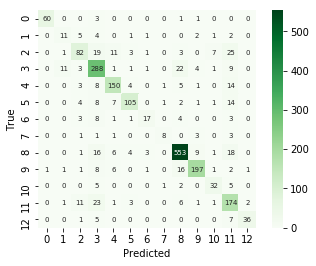

In [26]:
createConfusionMatrix(y_test ,predictions, my_df, target, metrics)